<a href="https://colab.research.google.com/github/the-SQuAD-squad/IR/blob/main/IR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Init { form-width: "25%" }
import os
import random
import math
import numpy as np
import json
import pandas as pd
import re
import string

from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

!nvidia-smi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


Sat Feb 27 11:35:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    40W / 300W |   1453MiB / 16160MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title df creation { form-width: "25%" }

# the official dataset is identical to the provided one
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O training_set.json

with open("training_set.json", "r") as f:
    json_file = json.load(f)
data = json_file["data"]

rows = []
for document in data:
  for par in document['paragraphs']:
    for qas in par['qas']:
      rows.append({
        'id' : qas['id'],
        'title': document["title"],
        'passage': par['context'],
        'question' : qas['question'],
        'answer_idx' : (qas['answers'][0]['answer_start'], 
                    qas['answers'][0]['answer_start'] + len(qas['answers'][0]['text'])),
        'answer_text' : qas['answers'][0]['text']
      })

df_original = pd.DataFrame(rows)

--2021-02-27 10:56:53--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘training_set.json’

training_set.json   100%[===================>]  28.88M   111MB/s    in 0.3s    

2021-02-27 10:56:54 (111 MB/s) - ‘training_set.json’ saved [30288272/30288272]



In [ ]:
#@title preprocessing { form-width: "25%" }

import nltk
import re 
import math
import random as rand

nltk.download('punkt')
from nltk.stem.porter import PorterStemmer # for stemming

from tqdm.notebook import tqdm


def preprocess_text(text):
    """
    Given an iterable containing sentences, pre-process each sentence.

    :param: 
        - text: list of text to be pre-processed (Iterable)
    :return:
        - text: pre-processed text (List)
    """

    REPLACE_WITH_SPACE = re.compile(r"\n") 
    text = [REPLACE_WITH_SPACE.sub(" ", line) for line in text]

    # we don't remove symbols, but just put a space before and after them. We did this because we noticed that Glove contains an embedding also for
    # them, so, in this way, we are able to split these symbols from the text when computing sentence tokens
    text = [re.sub(r"([(.;:!\'ˈ~?,\"(\[\])\\\/\-–\t```<>_#$€@%*+—°′″“”×’^₤₹‘])", r'', line) for line in text]

    # we noticed that in the text sometimes we find numbers and the following word merged together (ex: 1980february),
    # so we put a space between the number and the word
    text = [re.sub(r"(\d+)([a-z]+)", r'\1 \2', line) for line in text] 
    text = [re.sub('\s{2,}', ' ', line.strip()) for line in text]   # replacing more than one consecutive blank spaces with only one of them

    return text

    stemmed_lines = []
    for line in tqdm(text):
        tokens = nltk.word_tokenize(line)
        stems = []
        for item in tokens:
            stems.append(PorterStemmer().stem(item))
        stemmed_lines.append(' '.join(stems))

    return stemmed_lines

# Creating a copy of the original dataframe (we do this because we want to be able to compare the results of our processing with the original data)
df = df_original.copy()

# pre-process passage and question text
df['passage'] = preprocess_text(df_original['passage'])
df['question'] = preprocess_text(df_original['question'])
df['answer_text'] = preprocess_text(df_original['answer_text'])


# Comparing Original and Pre-Processed
for i in range(3):
    a = rand.randint(0,1000)
    print('ORIGINAL AND PREPROCESSED PASSAGE:')
    print(df_original.iloc[a]['passage'])
    print(df.iloc[a]['passage'])
    
    print()
    print('ORIGINAL AND PREPROCESSED QUESTION:')
    print(df_original.iloc[a]['question'])
    print(df.iloc[a]['question'])
    print()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
ORIGINAL AND PREPROCESSED PASSAGE:
In 2015 Beyoncé signed an open letter which the ONE Campaign had been collecting signatures for; the letter was addressed to Angela Merkel and Nkosazana Dlamini-Zuma, urging them to focus on women as they serve as the head of the G7 in Germany and the AU in South Africa respectively, which will start to set the priorities in development funding before a main UN summit in September 2015 that will establish new development goals for the generation.
In 2015 Beyoncé signed an open letter which the ONE Campaign had been collecting signatures for the letter was addressed to Angela Merkel and Nkosazana DlaminiZuma urging them to focus on women as they serve as the head of the G7 in Germany and the AU in South Africa respectively which will start to set the priorities in development funding before a main UN summit in September 2015 that will establish new

In [ ]:
df["passage"]=df["passage"].str.lower()
df["question"]=df["question"].str.lower()
df["answer_text"]=df["answer_text"].str.lower()

In [ ]:
#@title clean dataset { form-width: "25%" }

!gcloud config set project feisty-mechanic-221914
!gsutil cp gs://squad_squad/error_IDs.txt ./error_IDs.txt

with open("error_IDs.txt", "r") as f:
    unwanted_id = f.read()

unwanted_id = unwanted_id.split("\n")[:-1]
df_clean = df.set_index('id')
df_clean = df_clean.drop(unwanted_id)

df_original_clean = df_original.set_index('id')
df_original_clean = df_original_clean.drop(unwanted_id)

Updated property [core/project].
Copying gs://squad_squad/error_IDs.txt...
/ [1 files][  5.7 KiB/  5.7 KiB]                                                
Operation completed over 1 objects/5.7 KiB.                                      


In [ ]:
#@title split { form-width: "25%" }

split_value = 0.1 #@param {type:"number"} 
val_dim = int(len(df_clean['title'].unique()) * split_value)
val_titles = np.random.choice(df_clean['title'].unique(), size=val_dim, replace=False)

# creating train and val sets
df_val = df_clean[df_clean['title'].isin(val_titles)]
df_train = df_clean[~(df_clean['title'].isin(val_titles))]

df_original_val = df_original_clean[df_original_clean['title'].isin(val_titles)]
df_original_train = df_original_clean[~(df_original_clean['title'].isin(val_titles))]

passage_prep_train = df_train['passage'].unique().tolist()
passage_train = df_original_train['passage'].unique().tolist()

In [ ]:
vectorizer =  TfidfVectorizer()
# tokenization and creation of Bag of Words representation
passage_tf_idf = vectorizer.fit_transform(passage_prep_train)

# we keep track of the original passage index before performing unique()

passage_prep_val = df_val['passage'].unique().tolist() # preprocessed
passage_val = df_original_val['passage'].unique()      # original

passage_val_tf_idf = vectorizer.transform(passage_prep_val)
question_tf_idf = vectorizer.transform(df_val['question'].tolist())

results = cosine_similarity(passage_val_tf_idf, question_tf_idf)


[0.5450475657526581, 0.6624230554001119, 0.7250979294907667]


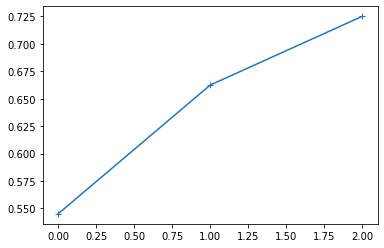

In [ ]:
# single passage scores
k_results = 3

tp = 0 #true positives
accuracy = []
for k in tqdm(range(1, k_results+1)):
    for j,result in enumerate(results.T):
        result = np.argsort(result)
        if df_original_val['passage'].tolist()[j] in [text for text in passage_val[result[-k:].tolist()]]:
            tp+=1
    accuracy.append(tp/len(df_original_val))
    tp = 0

print(accuracy,sep='\n')
plt.plot(accuracy,"-+");

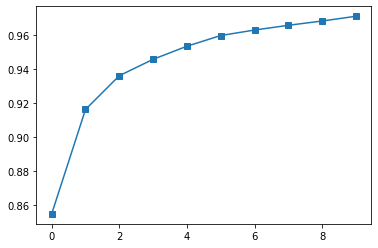

In [ ]:
# full document (title) scores
passage_group = df_original_val.groupby('passage').groups

k_results = 15
tp = 0
document_accuracy = []
for k in tqdm(range(1,11)):
    for j,result in enumerate(results.T):
        result = np.argsort(result)
        for h in range(1,k+1):
            if df_original_val.loc[passage_group[df_original_val['passage'].tolist()[j]][0]]['title'] == df_original_val.loc[passage_group[passage_val[result[-h]]][0]]['title']:
                tp+=1
                break
    document_accuracy.append(tp/len(df_original_val))
    tp = 0

plt.plot(document_accuracy,"-s")

In [ ]:
#@title kNN cosine { form-width: "25%" }

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

k=16
tree = NearestNeighbors(n_neighbors=k, metric='cosine')
tree.fit(passage_val_tf_idf)

results = tree.kneighbors(question_tf_idf, n_neighbors=k, return_distance=False)

ok=0
for i in range(len(results)):
    for j in range(k):
        if df_original_val['passage'].iloc[i] == passage_val[results[i,j]]:
            ok+=1

ok/len(results)

0.9057078903189704

# ELECTRA 2nd stage

In [ ]:
#@title Init { form-width: "25%" }

!pip install tokenizers
!pip install transformers

import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

from tokenizers import BertWordPieceTokenizer

import transformers
from transformers import AutoTokenizer
pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# BERT params
max_seq_length = 512

# Huggingface bert and associated tokenizer
pretrained_model_str = "google/electra-small-discriminator"

bert_hf_layer = transformers.TFElectraModel.from_pretrained(
    pretrained_model_str, output_attentions=True)

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_str)

!nvidia-smi

     |████████████████████████████████| 1.9MB 12.8MB/s 
     |████████████████████████████████| 890kB 58.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=3c26b423af605edfca51370773311885c16f4a11deb8cb1a092c0f2694832c3b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-small-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.



Sat Feb 27 11:37:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    40W / 300W |   1511MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+------

In [ ]:
#@title clean dataset { form-width: "25%" }

!gcloud config set project feisty-mechanic-221914
!gsutil cp gs://squad_squad/error_IDs.txt ./error_IDs.txt

with open("error_IDs.txt", "r") as f:
    unwanted_id = f.read()

unwanted_id = unwanted_id.split("\n")[:-1]
df_bert = df_original.set_index('id')
df_bert = df_bert.drop(unwanted_id)
df_bert.head()

Updated property [core/project].
Copying gs://squad_squad/error_IDs.txt...
/ [1 files][  5.7 KiB/  5.7 KiB]                                                
Operation completed over 1 objects/5.7 KiB.                                      


,title,passage,question,answer_idx,answer_text
id,,,,,
5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,"(515, 541)",Saint Bernadette Soubirous
5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is in front of the Notre Dame Main Building?,"(188, 213)",a copper statue of Christ
5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",The Basilica of the Sacred heart at Notre Dame is beside to which structure?,"(279, 296)",the Main Building
5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is the Grotto at Notre Dame?,"(381, 420)",a Marian place of prayer and reflection
5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary rep

In [ ]:
#@title BERT preprocessing { form-width: "25%" }
from tqdm import tqdm

def preprocess_bert(text):
    tokenized_text = tokenizer(list(text), padding="max_length", max_length=max_seq_length, truncation=True)
    return tokenized_text.input_ids

print("Preprocessing passage...")
unique_passage = df_original_val['passage'].unique()
df_bert_preprocessed_val_passages = preprocess_bert(unique_passage)
print("Preprocessing question...")
df_bert_preprocessed_val_questions = preprocess_bert(df_original_val['question'])


Preprocessing passage...
Preprocessing question...


In [ ]:
#@title model definition { form-width: "25%" }
import tensorflow as tf
from tensorflow.keras.losses import cosine_similarity, MSE, mae

input_passage_ids = tf.keras.layers.Input(batch_input_shape=(16, max_seq_length,), dtype=tf.int32, name='input_passage_ids')
input_question_ids = tf.keras.layers.Input(batch_input_shape=(16, max_seq_length,), dtype=tf.int32, name='input_question_ids')

bert_hf_layer = transformers.TFElectraModel.from_pretrained(pretrained_model_str)

passage_encoding = bert_hf_layer(input_ids=[input_passage_ids]).last_hidden_state[:,0]
question_encoding = bert_hf_layer(input_ids=[input_question_ids]).last_hidden_state[:,0]

densep = tf.keras.layers.Dense(512, activation='relu')
densep1 = tf.keras.layers.Dense(256)
denseq = tf.keras.layers.Dense(512, activation='relu')
denseq1 = tf.keras.layers.Dense(256)

outp = densep(passage_encoding)
outp1 = densep1(outp)
outq = denseq(question_encoding)
outq1 = denseq1(outq)

outdot = tf.tensordot(outp1, outq1, axes=(1,1))

softmax = tf.keras.layers.Softmax(axis=0)
output = softmax(outdot)

model = keras.Model(inputs=[input_passage_ids, input_question_ids], 
                    outputs=output,
                    name="BERT_IR")

model.summary(line_length=150)

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-small-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "BERT_IR"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_passage_ids (InputLayer)                   [(16, 512)]                      0                                                                   
______________________________________________________________________________________________________________________________________________________
input_question_ids (InputLayer)                  [(16, 512)]                      0                                                                   
______________________________________________________________________________________________________________________________________________________
tf_electra_model_1 (TFElectraModel)              TFBaseModelOutput(last_hidde

In [ ]:
!wget https://api.wandb.ai/files/veri/IR/191egtdh/model-best.h5

model.load_weights('model-best.h5')

bert_hf_layer.set_weights(model.layers[2].get_weights())
densep.set_weights(model.layers[5].get_weights())
denseq.set_weights(model.layers[6].get_weights())
densep1.set_weights(model.layers[7].get_weights())
denseq1.set_weights(model.layers[8].get_weights())

input_txt_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32)
output = bert_hf_layer(input_ids=input_txt_ids).last_hidden_state[:,0]
outp = densep(output)
outp = densep1(outp)
passage_encoder = keras.Model(inputs=input_txt_ids, outputs=outp)
outq = denseq(output)
outq = denseq1(outq)
question_encoder = keras.Model(inputs=input_txt_ids, outputs=outq)

encoded_val_passage = np.zeros((len(df_bert_preprocessed_val_passages), 256))
encoded_val_question = np.zeros((len(df_bert_preprocessed_val_questions), 256))
passages = np.stack(df_bert_preprocessed_val_passages)
questions = np.stack(df_bert_preprocessed_val_questions)

batch_size=16

for i in tqdm(range(len(df_bert_preprocessed_val_passages)//batch_size)):
    encoded_val_passage[i*batch_size : (i+1)*batch_size] = passage_encoder(passages[i*batch_size : (i+1)*batch_size])

for i in tqdm(range(len(df_bert_preprocessed_val_questions)//batch_size)):
    encoded_val_question[i*batch_size : (i+1)*batch_size] = question_encoder(questions[i*batch_size : (i+1)*batch_size])

--2021-02-27 11:57:57--  https://api.wandb.ai/files/veri/IR/191egtdh/model-best.h5
Resolving api.wandb.ai (api.wandb.ai)... 35.186.228.49
Connecting to api.wandb.ai (api.wandb.ai)|35.186.228.49|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://storage.googleapis.com/wandb-production.appspot.com/veri/IR/191egtdh/model-best.h5?Expires=1614427137&GoogleAccessId=wandb-production%40appspot.gserviceaccount.com&Signature=D7HJRs0yzwbeYMcaetpD%2FZoFE8LWSFh90jCjiFchpeLF1kJCKGZy5EUYOBvH1m0VY0wYunWtRI9cEt%2FGQXdS2TyeiNgiHHBnyf3aZ7InGYZVZoJgXLXd8Sz6LptiqPi3MXuq0B84AjMkxYS11kQ6qGpzI8ECNxW%2BEML0X%2BxppeZgG3ZU%2BL5gkErRVQEThkvhbX85S6vil1ZyFRM%2BWxaaYL6kTuMzaY2z%2BxQgZcTJBZPD1IKzrTLCmKNGRYN9Uli4YM55GvjPObQOjV6IyFypZ2b%2BRsLBc0bOzn9BoSySoFJu9Q8jWlIZv0dq2bvW1i6Sz%2Fez6tWJLi%2BHHoO6SEQKdQ%3D%3D [following]
--2021-02-27 11:57:57--  https://storage.googleapis.com/wandb-production.appspot.com/veri/IR/191egtdh/model-best.h5?Expires=1614427137&GoogleAccessId=w

100%|██████████| 446/446 [00:28<00:00, 15.48it/s]


In [ ]:
#@title argmax evaluation and plot { form-width: "25%" }

import matplotlib.pyplot as plt

a = tf.keras.layers.Input(shape=(256,), dtype=tf.float32)
b = tf.keras.layers.Input(shape=(256,), dtype=tf.float32)
outdot = tf.tensordot(a, b, axes=(1,1))
softmax = tf.keras.layers.Softmax(axis=0)
output = softmax(outdot)
classifier = keras.Model(inputs=[a,b], outputs=output)

acc = []
ok = 0
for r in tqdm(range(results.shape[0])):
    
    pred = classifier.predict((encoded_val_passage[results[r]], np.repeat(encoded_val_question[r,np.newaxis], 16, axis=0)), 
                            batch_size=batch_size)

    pred = tf.argmax(pred, axis=0)[0]

    passage_idx = results[r, pred]

    if unique_passage[passage_idx] == df_original_val.iloc[r]['passage']:
        ok += 1

ok/results.shape[0]

100%|██████████| 7148/7148 [04:03<00:00, 29.40it/s]


0.25993284834918856